# __Final Assignment__
### __Machine Learning and Neural Networks__

# Introduction

In this assignment, I will be doing image classification using the CIFAR-10 dataset that is available as part of the Keras library.
Our input consists of 60000 32x32 colour images (3 channels) with 10 different classes, 6000 images per class.
There are 50000 training images and 10000 test images [1].
This is a multiclass, single-label classification and our labels can have the following classes:

| Label | Description  |
| ----- |--------------|
| 0     | airplane     |
| 1     | automobile   |
| 2     | bird         |
| 3     | cat          |
| 4     | deer         |
| 5     | dog          |
| 6     | frog         |
| 7     | horse        |
| 8     | ship         |
| 9     | truck        |


Because each class has the same number of samples we have a balanced-classification problem.
Therefore, we will use accuracy to measure the performance of the models. If we had an unbalanced problem we would have to use other metrics like R2 score or use weights in our samples. For example, if we had a classification with the classes in a ratio of 1 to 100, a model that made a prediction that all samples are of class 2 would have 99% accuracy.

In [1]:
import tensorflow.keras as keras
from keras.datasets import cifar10
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers


# loading traning data and test data from cifar dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('X_train shape:', X_train.shape)
print('Train sample count:', X_train.shape[0])
print('Test sample count:', X_test.shape[0])
print('Classes available:', np.unique(y_train[:, :]))


170508288/170498071 [==============================] - 3s 0us/step
X_train shape: (50000, 32, 32, 3)
Train sample count: 50000
Test sample count: 10000
Classes available: [0 1 2 3 4 5 6 7 8 9]


Example images included in the dataset


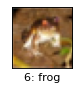

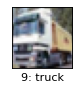

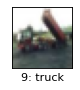

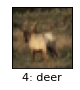

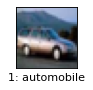

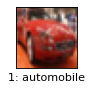

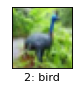

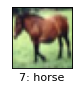

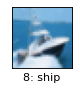

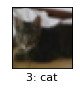

In [2]:
# Plot functions

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, auc

# plot the train / validation loss
def plot_loss_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# plot sample images
def plot_image(x, y=None, label_names=None):
    figure(figsize=(1,1 ), dpi=80)
    plt.imshow(x)
    plt.xticks([])
    plt.yticks([])
    if y is not None and label_names is not None:
      plt.xlabel(str(y[0]) + ": " + label_names[y[0]])
    plt.show()


print('Example images included in the dataset')

label_names = ["airplane","automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for idx in range(10):
    plot_image(X_train[idx], y_train[idx], label_names)

# Methodology

## Dumb baseline

Our first step is to create a small model to validate that our samples have statistical power.
Even a basic model should have results better than a random guess.
A random guess would be correct around 10% of the time since we have 10 different classes.

In [3]:
classes = np.unique(y_train[:, :])
num_classes = classes.shape[0]

guess_accuracy = 1 / num_classes

print("Number of classes: ", num_classes)
print("Dumb baseline accuracy: ", guess_accuracy)

Number of classes:  10
Dumb baseline accuracy:  0.1


## Preprocessing

### One-hot encoding
To build our models we need first to one-hot encode our labels.
The target array "y" represents each label as a integer ranging from 0 to 9.
We can't use integers in our classification, we need to transform "y" into array with shape (number of samples, number of classes)
containing only zeros and ones.

### Normalizing
It's not a good practice to use large values as input data into a artificial neural network.
Each pixel of the input images has three values ranging from 0 to 255 representing the channels red, green, blue.
Before feeding this data into the neural network, I am dividing each channel by 255 to get values ranging from 0 to 1.
Normalizing avoid problems with the gradient updates that can prevent our model to converge to the minimum loss [3].
I am also converting the input values to "float32" arrays to fit Tensorflow expectations and avoid compilation problems.


Sample image after normalizing


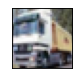

y shape after one-hot encoding


(50000, 10)

In [4]:
# normalize and one-hot encode
def encode_norm(X, y, num_classes):
    y = keras.utils.to_categorical(y, num_classes)
    X = X.astype('float32')
    X = X.astype('float32')
    X /= 255
    return X, y

X_train, y_train = encode_norm(X_train, y_train, num_classes)
X_test, y_test = encode_norm(X_test, y_test, num_classes)

input_shape = X_train.shape[1:]

print("y shape after one-hot encoding")
y_train.shape

## Evaluation protocol
I will use the strategy of maintaining a hold-out validation set to evaluate each model. We have enough images to be able to train models and compare the results to choose the best architecture and hyperparameters. As we are working with images, training would be very slow if we use K-fold cross-validation.

## Model base architecture

### Last layer activation function

I will be using "softmax" activation in all model tests.
Softmax is indicated when we have a multilabel classification with a single category as output [4].
The values returned by this function represent a distribution of probabilities between each category that sum to 1.
The predicted category is the one with the highest probability among the values returned.

### Loss function

The loss function I am using is the categorical crossentropy function:

$Loss = - \sum_{i=1}^{n_c} y_i * \log \hat{y_i} $

where $\hat{y_i}$ is each predicted label probability, $y_i$ is the real label probability and $c_n$ is the number of classes.
Categorical crossentropy is a good fit when we have a discrete probability distribution and we want to know how "far" is this
distribution from another one [5].

###  The "build_and_run_model" function

Below I created a function that takes a Keras model and completes it by adding the last layer and defining the loss function and optimizer.
This function also runs the model and returns information about its performance.

In [5]:
def build_and_run_model(model, epochs, batch_size, input_shape=None, add_dense=None):
    validation_split = 0.2

    if (input_shape is None):
        model.add(layers.Flatten())
    else:
        model.add(layers.Flatten(input_shape=input_shape))

    if add_dense is not None:
      model.add(layers.Dense(add_dense, activation="relu"))
    
    model.add(layers.Dense(num_classes, activation="softmax"))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size, verbose=0)
    plot_loss_history(history)
    scores = model.evaluate(X_test, y_test)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])


### Basic model

Below I create and run the simplest possible model to check if our samples have statistical power and provide better results than a guess with 10% accuracy.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 10)                30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


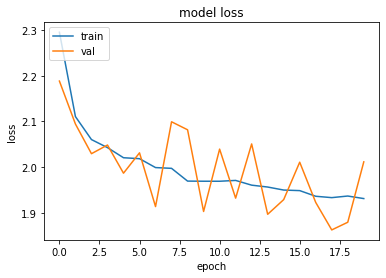

313/313 [==============================] - 1s 3ms/step - loss: 1.9816 - accuracy: 0.3240
Test loss: 1.9815887212753296
Test accuracy: 0.3240000009536743


In [6]:

model = Sequential()
build_and_run_model(model, 20, 400, input_shape=input_shape)


This model using only a dense layer achieved an accuracy of 30-40% proving that our samples have statistical value.
Looking at the plot relating the loss to the number of epochs, we see that the train loss converge to a minimum value but the validation loss oscilates a lot (sometimes it also converges by chance).
The way that validation loss oscillates shows that our model needs changes to be able to generalize the problem in a consistent way. It seems that the model lacks a better representation of sample features and also a greater capacity.

## Simple convolution model

n this next test, we will use a convolution layer to try to better fit our model to the problem at hand.
Dense layers are good for learning general patterns about our samples.
However, images contain local patterns that have high statistical value but present themselves differently in each sample.
For example, a wheel in an image has a high value to indicate that the sample contains a vehicle.
However, this wheel can appear in different sizes and positions within the image, not allowing dense layers alone to capture this pattern.
Convolution layers have the following features that are useful to us:
- Patterns learned are not affected by the position where they appear in the image
- When using multiple convolution layers, our model can learn hierarchies of patterns where a second layer can learn large patterns on top of the patterns of the first layer




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                81930     
                                                                 
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


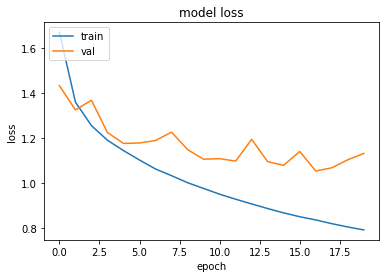

313/313 [==============================] - 1s 4ms/step - loss: 1.1336 - accuracy: 0.6195
Test loss: 1.1336369514465332
Test accuracy: 0.6194999814033508


In [7]:
model = Sequential()
model.add(layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
build_and_run_model(model, 20, 100)

## 2 layers convolution model

In the model below I am adding an additional layer of convolution to see if we can improve the model accuracy for the validation samples.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)               

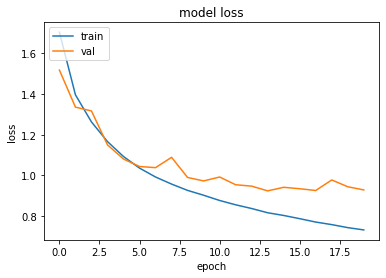

313/313 [==============================] - 1s 3ms/step - loss: 0.9263 - accuracy: 0.6838
Test loss: 0.926295816898346
Test accuracy: 0.6837999820709229


In [8]:

model = Sequential()
model.add(layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.MaxPooling2D())
build_and_run_model(model, 20, 100)

## 3 layers convolution model with an additional dense layer

With 2 convolution layers we got a slightly better result but no clear overfitting yet.
In this next test I am adding an additional dense layer with 256 units and another convolution layer to raise our model capacity and check if can achieve a strong overfitting to indicate that our model has enough capacity.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)        

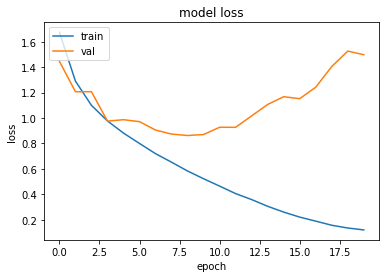

313/313 [==============================] - 1s 3ms/step - loss: 1.5556 - accuracy: 0.7146
Test loss: 1.55558443069458
Test accuracy: 0.7146000266075134


In [9]:
model = Sequential()
model.add(layers.Conv2D(32, 3, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, 3, activation="relu", padding='same'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(64, 3, activation="relu", padding='same'))
model.add(layers.MaxPooling2D(2))
build_and_run_model(model, 20, 100, add_dense=256)

To get a model to be used in production we would now have to __reduce the maximum number of epochs to 6__ and __train the model using all available samples__. With the epoch equal to 6 we would have a model without overfitting that would achieve good results in samples never seen before. But I believe we can still __reduce overfitting if we have more samples__.

## Data augmentation

Using data augmentation we can increase our number of images available for training. We can create new images from existing ones by applying resizing, translation and other image processing procedures. With more samples we hope to reduce the gap between training accuracy and evaluation accuracy. More data allows the model to obtain more generalized treinable parameters that allow for better accuracy in never-before-seen samples.


Original image


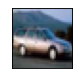

Images generated from the original image


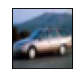

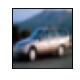

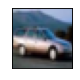

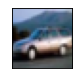

In [27]:
from keras.preprocessing import image

def build_complete_model(generator, X_val, y_val, epochs, batch_size, filter_size=3, dropout=0, learning_rate=0.001, show_test=True):

  model = Sequential()
  model.add(layers.Conv2D(32, filter_size, activation="relu", padding='same', input_shape=input_shape))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Conv2D(32, filter_size, activation="relu", padding='same'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, filter_size, activation="relu", padding='same'))
  model.add(layers.MaxPooling2D(2))
  
  if dropout != 0:
    model.add(layers.Dropout(dropout))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation="relu"))  
  model.add(layers.Dense(num_classes, activation="softmax"))
  model.summary()
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
                metrics=['accuracy'])

  history = model.fit(generator,
                      epochs=epochs,
                      batch_size=batch_size,
                      verbose=0,
                      validation_data=(X_val, y_val))
  
  
  plot_loss_history(history)

  if show_test is True:
    scores = model.evaluate(X_test, y_test)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

  # returns the minimum validation loss
  min_index = np.argmin(history.history['val_loss']) 
  return history.history['val_loss'][min_index], min_index 


datagen = ImageDataGenerator(
  # rotation_range=10,
  # width_shift_range=0.1,
  # height_shift_range=0.1,
  # shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest'  
)
datagen.fit(X_train)

print("Original image")
plot_image(X_train[4])

print("Images generated from the original image")

i = 0
for batch in datagen.flow(X_train[4:5], batch_size=1):
  plot_image(image.array_to_img(batch[0]))
  i += 1
  if i % 4 == 0:
    break


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_77 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 4, 4, 64)       

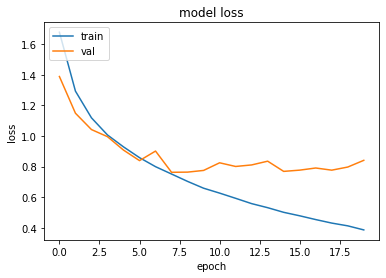

313/313 [==============================] - 1s 3ms/step - loss: 0.8793 - accuracy: 0.7540
Test loss: 0.879289448261261
Test accuracy: 0.7540000081062317


{'Without tunning': (0.7621309757232666, 7)}

In [28]:
X_val, y_val = X_train[:10000], y_train[:10000]
X_train2, y_train2 = X_train[10000:], y_train[10000:]

complete_model_results = {}

# fits the model on batches with real-time data augmentation:
data_generator = datagen.flow(X_train2, y_train2,  batch_size=100)
complete_model_results["Without tunning"] = build_complete_model(data_generator, X_val, y_val, batch_size=100, epochs=20)
complete_model_results

Using the training set together with the generated images we were able to increase the accuracy of the model. We can also see in the plot that the validation data loss is following the training data loss more closely. This will allow us to add more epochs and achieve even greater accuracy without overfitting.

## Hyperparameters tunning

Hyperparameter tuning allows us to automatically optimize the architecture of the model layers and also the value of non-trainable parameters. In the next cell, I am doing an experiment to evaluate how changes in the learning rate and the addition of a dropout layer affect the performance of the model. At each iteration, a permutation of settings is used to compare the differences in the results. Only the validation set can be used in this evaluation since using the training set would cause the model to be optimized for that specific set, not having the expected result when used in production.



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.01
Dropout:  0

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 8, 8, 64)          18496     
                                          

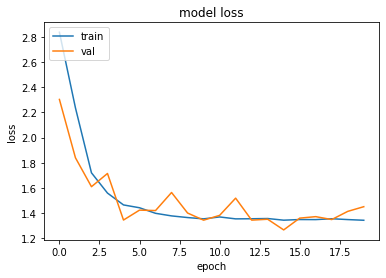



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.01
Dropout:  0.25

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_82 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_83 (Conv2D)          (None, 8, 8, 64)          18496     
                                       

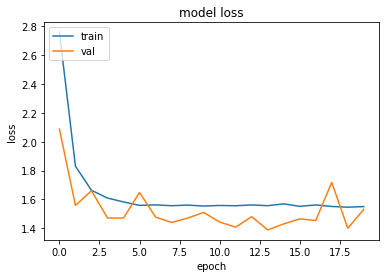



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.01
Dropout:  0.5

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 8, 8, 64)          18496     
                                        

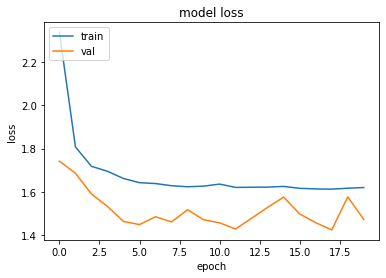



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.001
Dropout:  0

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_87 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_88 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_89 (Conv2D)          (None, 8, 8, 64)          18496     
                                         

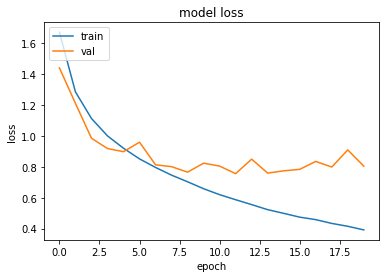



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.001
Dropout:  0.25

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_90 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 64)          18496     
                                      

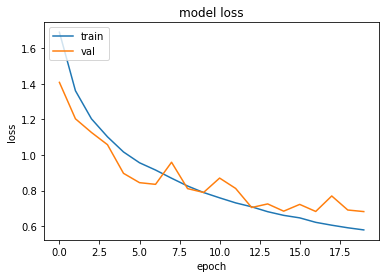



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.001
Dropout:  0.5

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_93 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 8, 8, 64)          18496     
                                       

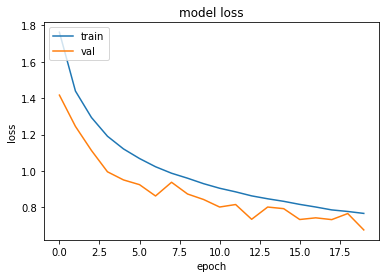



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.0001
Dropout:  0

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_96 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_97 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_97 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_98 (Conv2D)          (None, 8, 8, 64)          18496     
                                        

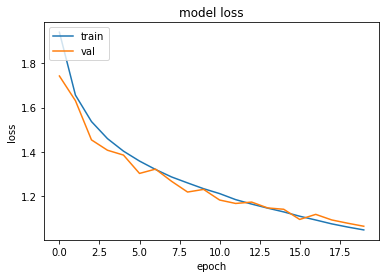



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.0001
Dropout:  0.25

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_99 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_99 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_100 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_101 (Conv2D)         (None, 8, 8, 64)          18496     
                                     

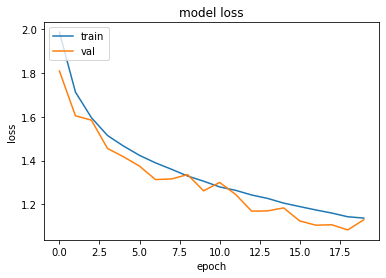



*** EVALUATING MODEL HYPERPARAMETERS ***
Learning rate:  0.0001
Dropout:  0.5

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_102 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_103 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_103 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_104 (Conv2D)         (None, 8, 8, 64)          18496     
                                      

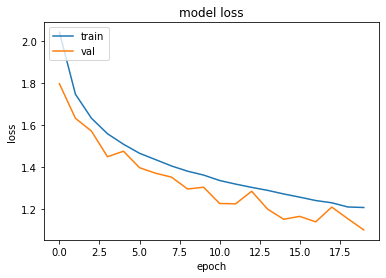

In [29]:
learning_rates = [0.01, 0.001, 0.0001]
dropouts = [0, 0.25, 0.5]

for learning_rate in learning_rates:
  for dropout in dropouts:
    print("")
    print("========================================")
    print("")
    print("*** EVALUATING MODEL HYPERPARAMETERS ***")
    print("Learning rate: ", str(learning_rate))
    print("Dropout: ", str(dropout))
    print("")
    complete_model_results[
                           "lr = " + str(learning_rate) + " | dropout = " + str(dropout)
                           ] = build_complete_model(data_generator, X_val, y_val, batch_size=100, epochs=20, dropout=dropout, learning_rate=learning_rate, show_test=False)

We did not achieve a better convergence of the loss to a minimum value in any of the hyperparameter tuning interactions. The ideal would be to run each iteration with more epochs but because we are using augmented data I restricted the training to have a faster result.

## Hyperparameters tunning results

Below we have a dataframe with the results of the hyperparameters tuning. The model that achieved a lower validation loss was the one with a learning rate of 0.001 and a dropout of 0.5. The smallest loss was reached on epoch 19, however we would probably get a smaller loss if we increased the number of epochs as we had no sign of overfitting. For the purposes of this assignment I will not do this because of the computational cost.



In [34]:

import pandas as pd

results_dataframe_data = [ [description, result[0], result[1]] for description, result in complete_model_results.items()]

df = pd.DataFrame(results_dataframe_data, columns=["Model description", "Validation loss", "Number of epochs"])
df.sort_values(by="Validation loss")

,Model description,Validation loss,Number of epochs
6,lr = 0.001 | dropout = 0.5,0.676941,19
5,lr = 0.001 | dropout = 0.25,0.682267,19
4,lr = 0.001 | dropout = 0,0.755084,11
0,Without tunning,0.762131,7
7,lr = 0.0001 | dropout = 0,1.065609,19
8,lr = 0.0001 | dropout = 0.25,1.083539,18
9,lr = 0.0001 | dropout = 0.5,1.102520,19
1,lr = 0.01 | dropout = 0,1.265485,14
2,lr = 0.01 | dropout = 0.25,1.388362,13
3,lr = 0.01 | dropout = 0.5,1.424157,17


# Results

Following an iterative workflow, we were able to adjust the architecture of our model to better meet the problem at hand. We defined that accuracy would be the best way to evaluate the performance of models since we have a balanced classification problem. We evaluate the models by separating the training, validation and test samples and pre-process them before feeding the models. We added more and more layers and capacity to our model to reach an overfit point where the model could capture the complexity of the samples. We used data augmentation techniques to increase the number of images available for training and increase the number of epochs needed to achieve overfit. Then we evaluated the change of hyperparameters automatically iterating over some possibilities seeking a better result.
Although we obtained much better results using the additional images generated, the additional images increased the computational cost of evaluating more hyperparameter permutations.

## Training production model

To train the production model I will use all available images (traning + test).

In [35]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])


X.shape, y.shape

((60000, 32, 32, 3), (60000, 10))

Now I will train the model using the best hyperparameters and number of epochs obtained in our evaluation:
- learning rate 0.001 
- dropout 0.5
- epoch 19

In [36]:
max_epochs = 19
learning_rate = 0.001
dropout = 0.5

datagen = ImageDataGenerator(
  #rotation_range=10,
  #width_shift_range=0.1,
  #height_shift_range=0.1,
  #shear_range=0.1,
  zoom_range=0.1,
  horizontal_flip=True,
  fill_mode='nearest'
)

filter_size = 3

datagen.fit(X_train)
generator = datagen.flow(X, y,  batch_size=200)

model = Sequential()
model.add(layers.Conv2D(32, filter_size, activation="relu", padding='same', input_shape=input_shape))
model.add(layers.MaxPooling2D(2))
model.add(layers.Conv2D(32, filter_size, activation="relu", padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, filter_size, activation="relu", padding='same'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(dropout))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))  
model.add(layers.Dense(num_classes, activation="softmax"))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['accuracy'])
model.fit(generator,
          epochs=max_epochs,
          batch_size=200,
          verbose=1)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_111 (MaxPooli  (None, 16, 16, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_112 (Conv2D)         (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_112 (MaxPooli  (None, 8, 8, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_113 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_113 (MaxPooli  (None, 4, 4, 64)       

## Using the model in production

To use the trained model in production to make predictions we cannot forget to
normalize the images we want to predict the class.

## References

[1] CIFAR-10 and CIFAR-100 datasets Available at: https://www.cs.toronto.edu/~kriz/cifar.html. (Accessed: 12th February 2022) 

[2] Chollet François. in Deep learning with python, Section 4.5.2 (Manning Publications Co., 2018). 

[3] Chollet François. in Deep learning with python, Section 4.3.1 (Manning Publications Co., 2018). 

[4] Tf.keras.losses.CategoricalCrossentropy &nbsp;: &nbsp; Tensorflow core v2.8.0. TensorFlow Available at: https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy. (Accessed: 12th February 2022) 

[5] Categorical crossentropy loss function: Peltarion platform. Peltarion Available at: https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy. (Accessed: 12th February 2022) 

[6] Chollet François. in Deep learning with python, Section 5.1.1 (Manning Publications Co., 2018). 